# Project 1: Query Project


In the Query Project, you will get practice with SQL while learning about Google Cloud Platform (GCP) and BiqQuery. You'll answer business-driven questions using public datasets housed in GCP. To give you experience with different ways to use those datasets, youb will use the web UI (BiqQuery) and the command-line tools, and work with them in Jupyter Notebooks.


You're a data scientist at [Lyft Bay Wheels](https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has several options which can change over time. Please visit the website to see the current offers and other marketing information. Frequent offers include:

- Single Ride
- Monthly Membership
- Annual Membership
- Bike Share for All
- Access Pass
- Corporate Membership
- etc.

In this project, we want to answer these questions:

- What are the 5 most popular trips that you would call "commuter trips"?
- What are your recommendations for offers (justify based on your findings)?

In [5]:
# Importing Relevant Packages
!pip install folium -q
!pip install geopandas -q
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import matplotlib.pyplot as plt

## Data Exploration

In this project, we will be looking at the following three datasets from San Francisco's Bikeshare:
- bikeshare_stations
- bikeshare_status
- bikeshare_trips

Here, we load the data using the magic commands to run BigQuery SQL for the `bikeshare_trips` data:

In [28]:
%%bigquery bikeshare_trips

SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

Downloading: 100%|██████████| 983648/983648 [00:02<00:00, 425253.00rows/s]


In [29]:
bikeshare_trips.shape

(983648, 11)

We can see the dimensions of this dataset consists of 983,648 trips and 11 features consisting of columns such as a unique trip_id, start dates, end dates, durations, subscriber type, etc. Below we load the first 5 rows of the data:

In [12]:
bikeshare_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


We want to know what the earliest start date and time and latest end date and time for a trip is in this dataset in order to see the timeperiod in which the data was collected. We use the Command Line Interface (CLI) to quickly get our result:

In [18]:
! bq query --use_legacy_sql=FALSE 'SELECT start_date FROM `bigquery-public-data.san_francisco.bikeshare_trips` ORDER BY start_date ASC LIMIT 1'

Waiting on bqjob_r1c9e3814b3520bf3_00000179e4d0cae5_1 ... (0s) Current status: DONE   
+---------------------+
|     start_date      |
+---------------------+
| 2013-08-29 09:08:00 |
+---------------------+


In [19]:
! bq query --use_legacy_sql=FALSE 'SELECT end_date FROM `bigquery-public-data.san_francisco.bikeshare_trips` ORDER BY end_date DESC LIMIT 1'

Waiting on bqjob_r541670a89164c3a2_00000179e4d0d687_1 ... (0s) Current status: DONE   
+---------------------+
|      end_date       |
+---------------------+
| 2016-08-31 23:48:00 |
+---------------------+


We can see the data starts from 8/29/2013 at 9:08 - 8/31/2016 at 23:48. 

<br><br>
## Data Cleaning

Next, we use the pandas `describe()` function to collect overall statistics of our dataset such as mean, minimums, maximums, etc.

In [13]:
bikeshare_trips.describe()

,trip_id,duration_sec,start_station_id,end_station_id,bike_number
count,9.836480e+05,9.836480e+05,983648.000000,983648.000000,983648.000000
mean,6.721238e+05,1.018932e+03,58.121022,58.100089,423.319779
std,3.851056e+05,1.841684e+04,16.841133,16.912386,158.071344
min,4.069000e+03,6.000000e+01,2.000000,2.000000,9.000000
25%,3.359168e+05,3.470000e+02,50.000000,50.000000,328.000000
50%,6.779755e+05,5.180000e+02,62.000000,62.000000,437.000000
75%,1.001672e+06,7.480000e+02,70.000000,70.000000,544.000000
max,1.338408e+06,1.727040e+07,91.000000,91.000000,878.000000


We can see that the maximum duration for a trip in this dataset is about 1.727040e+07 seconds. In addition, there are trips that are 60 seconds in duration. These extremely long and short trips are considered outliers, so we investigate them. First, we take the top 5 rows for the maximum and minimum durations:

In [204]:
%%bigquery

SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY duration_sec DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.08rows/s]


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,568474,17270400,2014-12-06 21:59:00+00:00,South Van Ness at Market,66,2015-06-24 20:18:00+00:00,2nd at Folsom,62,535,95531,Customer
1,825850,2137000,2015-06-28 21:50:00+00:00,Market at Sansome,77,2015-07-23 15:27:00+00:00,Yerba Buena Center of the Arts (3rd @ Howard),68,466,97213,Customer
2,750192,1852590,2015-05-02 06:17:00+00:00,San Antonio Shopping Center,31,2015-05-23 16:53:00+00:00,Castro Street and El Camino Real,32,680,94024,Subscriber
3,841176,1133540,2015-07-10 10:35:00+00:00,University and Emerson,35,2015-07-23 13:27:00+00:00,University and Emerson,35,262,94306,Customer
4,111309,722236,2013-11-30 13:29:00+00:00,University and Emerson,35,2013-12-08 22:06:00+00:00,University and Emerson,35,247,94301,Customer


The longest trip was 17,270,400 seconds (approx. 200 days) and started in South Van Ness at Market and ended at 2nd and Folsom. The possibilities for this case are:
1. The bike was lost or stolen than finally returned.
2. The bike had to be reprogrammed and configured for engineering testing.

Many other trips in this dataset also have a duration longer than a day which is not considered a "commuter trip." We want to limit our dataset to a maximum of 1 hour (i.e. approx. 3,600 seconds). Commuters in the Bay Area should not have trips longer than 1 hour. Therefore, we remove these outliers from our dataset:

In [205]:
bikeshare_trips = bikeshare_trips[bikeshare_trips['duration_sec'] < 3600]

The next query shows us that the start and end stations were the same and the trips only lasted 60 seconds. One possibility for this case is that a user might have thought about using the bike, but changed their mind and returned it.

In [206]:
%%bigquery

SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY duration_sec ASC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.12rows/s]


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,788322,60,2015-06-01 09:50:00+00:00,Howard at 2nd,63,2015-06-01 09:51:00+00:00,Howard at 2nd,63,238,94105,Subscriber
1,284638,60,2014-05-14 20:11:00+00:00,Market at 10th,67,2014-05-14 20:12:00+00:00,Market at 10th,67,372,94107,Subscriber
2,20271,60,2013-09-13 12:43:00+00:00,Market at 4th,76,2013-09-13 12:44:00+00:00,Market at 4th,76,500,94116,Subscriber
3,869535,60,2015-07-30 17:45:00+00:00,Howard at 2nd,63,2015-07-30 17:46:00+00:00,Howard at 2nd,63,382,90034,Customer
4,1011650,60,2015-11-16 18:54:00+00:00,Mezes,83,2015-11-16 18:55:00+00:00,Mezes,83,35,94124,Subscriber


Because these "short" trips are outliers and not considered "commuter trips", we simply remove them from our dataset. For this case, we will remove any trip that is shorter than 10 minutes (600 seconds):

In [207]:
bikeshare_trips = bikeshare_trips[bikeshare_trips['duration_sec'] >= 600]

In [208]:
bikeshare_trips.shape

(356941, 11)

After filtering out the outliers, we can see that our dataset decreased to 378,670 trips! To save our new 

<br><br>
## Data Visualizations

Next, we will conduct some analysis on commuter trips and create some visualizations to communicate our findings.

First, let's take a look at the duration of trips. We are only selecting trips above 600 seconds or 3,600 seconds because we are assuming that commuter trips should not be take longer 60 minutes. Customers and subscribers typicaally get charged extra every 15 minutes for going past 30 and 45 minutes, respectively.

In [209]:
%%bigquery duration_trips

SELECT duration_sec
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600)

Downloading: 100%|██████████| 360929/360929 [00:01<00:00, 288711.76rows/s]


In [210]:
duration_trips.shape

(360929, 1)

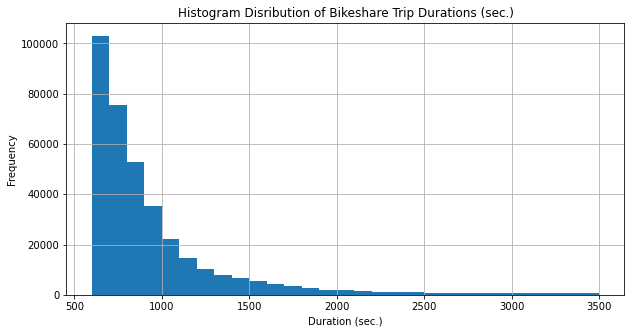

In [211]:
plt.figure(figsize=(10, 5))
duration_trips.duration_sec.hist(bins=range(600, 3600, 100))
plt.title('Histogram Disribution of Bikeshare Trip Durations (sec.)')
plt.xlabel("Duration (sec.)")
plt.ylabel("Frequency");

This is a right (or positively) skewed distribution indicating that there are a high number of trips with a duration of 600 seconds and then decreases in trip frequency as duration increases. This tells us that users typically want to have the shortest ride possible in order to decrease their cost per trip. For example, subscribers and customers have a 45 minute and 30 minute, respectively, for a maximum ride time until the ride cost increases by 2 - 3 dollars every 15 minutes.

Next, let's take a look at the hours in which these trips occur to see which hours are the most popular. We collect information about the subscriber type to see the distribution of these trips based on whether they were subscribers or customers.

In [116]:
%%bigquery bike_trips

SELECT subscriber_type, EXTRACT (HOUR FROM TIME(start_date)) AS trip_hour, COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600)
GROUP BY subscriber_type, trip_hour
ORDER BY trips DESC

Downloading: 100%|██████████| 48/48 [00:01<00:00, 34.47rows/s]


In [117]:
bike_trips.head()

,subscriber_type,trip_hour,trips
0,Subscriber,8,43575
1,Subscriber,17,40568
2,Subscriber,9,26891
3,Subscriber,16,26518
4,Subscriber,18,25988


Here, we can already see that the top 3 trip hours are at 8 AM, 5 PM, and 9 AM. Let's vizualize this further:

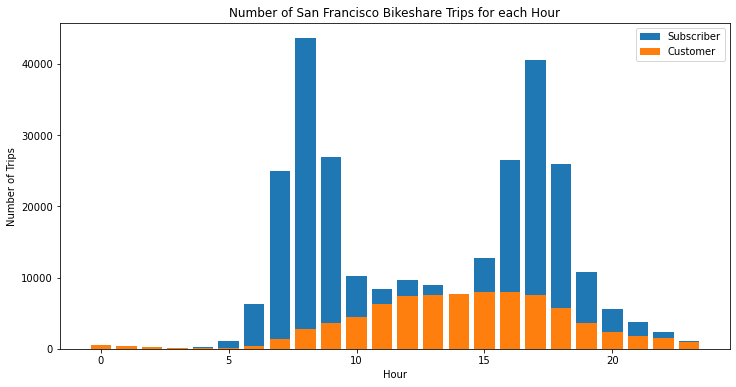

In [125]:
plt.figure(figsize=(12, 6))
plt.bar(bike_trips[bike_trips['subscriber_type'] == 'Subscriber']['trip_hour'], 
        bike_trips[bike_trips['subscriber_type'] == 'Subscriber']['trips'],
       label='Subscriber')
plt.bar(bike_trips[bike_trips['subscriber_type'] == 'Customer']['trip_hour'], 
        bike_trips[bike_trips['subscriber_type'] == 'Customer']['trips'], 
       label='Customer')
plt.title('Number of San Francisco Bikeshare Trips for each Hour')
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.legend();

Through this bar graph, we can see that subscribers dominate the trips, especially during peak hours. Even during peak hours, customers are also using the service.

Furthermore, we can see that the highest number of trips happen at 8 AM and 5 PM (17th hour). During these times, we can assume most users are commuting during and around this time. Therefore, we can filter the data again to include only trips during the time frame of 7 AM - 9 AM (leaving home and entering work) and 4 PM - 6 PM (leaving work and going home).

In [228]:
%%bigquery bike_trips

SELECT *, EXTRACT (HOUR FROM TIME(start_date)) AS trip_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR 
    (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18))

Downloading: 100%|██████████| 217429/217429 [00:01<00:00, 143983.49rows/s]


In [229]:
bike_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,trip_hour
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer,17
1,196047,1063,2014-02-25 18:29:00+00:00,Japantown,9,2014-02-25 18:46:00+00:00,Japantown,9,645,95112,Subscriber,18
2,542795,917,2014-11-13 09:16:00+00:00,Japantown,9,2014-11-13 09:31:00+00:00,Japantown,9,668,95122,Subscriber,9
3,1023243,783,2015-11-29 16:00:00+00:00,Japantown,9,2015-11-29 16:13:00+00:00,Japantown,9,676,95112,Subscriber,16
4,560981,621,2014-11-29 16:18:00+00:00,Japantown,9,2014-11-29 16:29:00+00:00,Japantown,9,117,95122,Subscriber,16


<br><br>
## Defining Commuter Trips

From the previous section, we were able to select trips that were only between a reasonable range (more than 600 seconds and less than 3,600 seconds). In addition, the most popular hours were 7 - 9 AM and 4 - 6 PM (typical work start and end times). Therefore, we selected only these hours assuming these trips were commuter trips.

We can also see in the previous table that there are trips that start and end at the same location. Since a commuter trip is defined as a trip from one's home and place of work, we can assume that these trips do not fall in that category. Therefore, we remove them.

In [232]:
%%bigquery commuter_trips

SELECT *, EXTRACT (HOUR FROM TIME(start_date)) AS trip_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR
     (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18)) AND
    (start_station_name != end_station_name)

Downloading: 100%|██████████| 213174/213174 [00:01<00:00, 137924.18rows/s]


In [234]:
commuter_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,trip_hour
0,1236584,627,2016-06-12 18:15:00+00:00,MLK Library,11,2016-06-12 18:26:00+00:00,Japantown,9,43,95407,Customer,18
1,1278755,845,2016-07-15 17:15:00+00:00,MLK Library,11,2016-07-15 17:29:00+00:00,Japantown,9,710,95109,Subscriber,17
2,8366,769,2013-09-01 18:31:00+00:00,MLK Library,11,2013-09-01 18:43:00+00:00,Japantown,9,77,,Customer,18
3,6323,2868,2013-08-30 18:36:00+00:00,MLK Library,11,2013-08-30 19:24:00+00:00,Japantown,9,52,95112,Customer,18
4,883725,1024,2015-08-10 18:33:00+00:00,MLK Library,11,2015-08-10 18:50:00+00:00,Japantown,9,107,95112,Subscriber,18


Furthermore, for someone to go to work on the weekend (Saturday or Sunday) is highly unlikely. Most people work on Mondays - Fridays. Therefore, we assume these trips do not fall under the category of "commuter trips" and thereby remove them from our data.

In [235]:
%%bigquery commuter_trips

SELECT *, EXTRACT (HOUR FROM TIME(start_date)) AS trip_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR
     (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18)) AND
    (start_station_name != end_station_name) AND
    (EXTRACT (DAYOFWEEK FROM start_date) IN (2, 3, 4, 5, 6))

Downloading: 100%|██████████| 197542/197542 [00:01<00:00, 106924.36rows/s]


In [236]:
commuter_trips.head()

(197542, 12)


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,trip_hour
0,1278755,845,2016-07-15 17:15:00+00:00,MLK Library,11,2016-07-15 17:29:00+00:00,Japantown,9,710,95109,Subscriber,17
1,6323,2868,2013-08-30 18:36:00+00:00,MLK Library,11,2013-08-30 19:24:00+00:00,Japantown,9,52,95112,Customer,18
2,883725,1024,2015-08-10 18:33:00+00:00,MLK Library,11,2015-08-10 18:50:00+00:00,Japantown,9,107,95112,Subscriber,18
3,151953,669,2014-01-13 18:09:00+00:00,MLK Library,11,2014-01-13 18:20:00+00:00,Japantown,9,180,95112,Subscriber,18
4,826984,683,2015-06-29 17:05:00+00:00,MLK Library,11,2015-06-29 17:16:00+00:00,Japantown,9,150,95112,Subscriber,17


When we join this table with the longitude and latitudes station locations for the start and end stations, we can see where the majority of people travel to work.

For this example, we will collect the coordinates for the starting bike trips in San Francisco and counting the number of trips:

In [131]:
%%bigquery start_bike_trips

SELECT latitude, longitude, start_station_name, COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations`
ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id = `bigquery-public-data.san_francisco.bikeshare_stations`.station_id
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR
     (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18)) AND
    (start_station_name != end_station_name) AND
    (EXTRACT (DAYOFWEEK FROM start_date) IN (2, 3, 4, 5, 6)) AND
    (landmark = 'San Francisco')
GROUP BY latitude, longitude, start_station_name

Downloading: 100%|██████████| 39/39 [00:01<00:00, 28.15rows/s]


In [132]:
start_bike_trips.head(2)

,latitude,longitude,start_station_name,trips
0,37.781752,-122.405127,5th at Howard,1537
1,37.786978,-122.398108,Howard at 2nd,2086


Next, we collect them for the ending bike trips in San Francisco and counting the number of trips as well:

In [133]:
%%bigquery end_bike_trips

SELECT latitude, longitude, end_station_name, COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations`
ON `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_id = `bigquery-public-data.san_francisco.bikeshare_stations`.station_id
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR
     (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18)) AND
    (start_station_name != end_station_name) AND
    (EXTRACT (DAYOFWEEK FROM start_date) IN (2, 3, 4, 5, 6)) AND
    (landmark = 'San Francisco')
GROUP BY latitude, longitude, end_station_name

Downloading: 100%|██████████| 39/39 [00:01<00:00, 30.71rows/s]


In [134]:
end_bike_trips.head(2)

,latitude,longitude,end_station_name,trips
0,37.785299,-122.396236,2nd at Folsom,1446
1,37.781752,-122.405127,5th at Howard,1640


Then, we combine this information to plot the locations of the start (blue) and end locations (red) for these commuter trips based on the number of trips at these stations.

In [136]:
sf_bike_map = folium.Map(location=[37.7847, -122.4069], tiles='openstreetmap', zoom_start=13)

for idx, row in start_bike_trips.iterrows():
    folium.CircleMarker(location = [row['latitude'], row['longitude']], radius=float(row['trips'] / 800),
                weight=1.5, color='blue', fill=True, fill_color='blue',
                tooltip=row['start_station_name'] + ' <br> Number of Trips: ' + str(row['trips'])).add_to(sf_bike_map)

for idx, row in end_bike_trips.iterrows():
    folium.CircleMarker(location = [row['latitude'], row['longitude']], radius=float(row['trips'] / 800),
                weight=1.5, color='crimson', fill=True, fill_color='crimson',
                tooltip=row['end_station_name'] + ' <br> Number of Trips: ' + str(row['trips'])).add_to(sf_bike_map)
    
sf_bike_map

This geospatial visualization shows us the density of the number of trips at a given station. If we hover over the map we can see that the two highest densities (i.e. greatest number of trips in a station) are at San Francisco Caltrain (Townsend at 4th) and Townsend at 7th. 

# <br><br>
## Conclusion

Originally we were posed with the following question:

> **Question 1:** What are the 5 most popular trips that you would call "commuter trips"?

After conducting data exploration, data cleaning, creating visualizations, and analyzing the data, we can finally come to a conclusion about the definition of commuter trips given our assumptions. These assumptions about commuter trips are outlined below:

- Trips that are longer than 600 seconds and shorter than 3,600 seconds
- Trips that happen in the weekdays
- Non-roundtrips (i.e. trips whose start and end locations are not the same)
- Trips that happen within the hours of 7 - 9 AM and 4 - 6 PM (typical work start and end times)

The final query that results in commuter trips given the above mentioned assumptions made about the data, is provided below:

In [109]:
%%bigquery final_commuter_trips

SELECT *, EXTRACT (HOUR FROM TIME(start_date)) AS trip_hour
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec BETWEEN 600 AND 3600) AND
    ((EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 7 AND 9) OR
     (EXTRACT (HOUR FROM TIME(start_date)) BETWEEN 16 AND 18)) AND
    (start_station_name != end_station_name) AND
    (EXTRACT (DAYOFWEEK FROM start_date) IN (2, 3, 4, 5, 6))

Downloading: 100%|██████████| 197542/197542 [00:01<00:00, 150866.84rows/s]


In [110]:
final_commuter_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,trip_hour
0,1278755,845,2016-07-15 17:15:00+00:00,MLK Library,11,2016-07-15 17:29:00+00:00,Japantown,9,710,95109,Subscriber,17
1,6323,2868,2013-08-30 18:36:00+00:00,MLK Library,11,2013-08-30 19:24:00+00:00,Japantown,9,52,95112,Customer,18
2,883725,1024,2015-08-10 18:33:00+00:00,MLK Library,11,2015-08-10 18:50:00+00:00,Japantown,9,107,95112,Subscriber,18
3,151953,669,2014-01-13 18:09:00+00:00,MLK Library,11,2014-01-13 18:20:00+00:00,Japantown,9,180,95112,Subscriber,18
4,826984,683,2015-06-29 17:05:00+00:00,MLK Library,11,2015-06-29 17:16:00+00:00,Japantown,9,150,95112,Subscriber,17


<br>

### Recommendations

Lastly, we were posed with the final question:

> **Question 2:** What are your recommendations for offers (justify based on your findings)?

Based on my analysis, some recommendations I would give for offers are the following:
    
- Add more bikes at popular station locations. The highest number of trips happen at San Francisco Caltrain (Townsend at 4th). Most users might be using the bike share service to get to the Caltrain or to go to work after riding the Caltrain. Increasing bikes (supply) would most likely increase the number of users (demand).

- Following the point above, we can promote via advertisements to offer first-time users at popular commuter station locations a discounted rate (or free trial) for membership to increase the number of users on the platform.

- Provide discounted membership rates for customers who share trips in common with those who are members. We can recommend, for example, a notice on the app stating: "Many bikers in your area, use our service to commute as members. Would you like to try our membership subscription for a discounted rate?" This could potentially increase revenue for the company while offering customers an opportunity to join the membership program.

- Recommend the annual membership plan (Bike Share for All) for commuters who qualify based on the income restrictions and use the service frequently. Show the users how much money they would save compared to how much they typically spend on their current plans.

- Users who commute using the bike share service and take longer to reach their destination might benefit from a membership or annual membership to decrease their overall cost.

- The bike share service can partner with coffee shops, bakeries, or sandwhich/breakfast shops nearby popular commuter stations and provide discounts to these users in order to increase revenue for both parties.